# IF5281 Deep Learning - Tugas UAS Semester II 2023/2024
## Nama : Nabila Hannania
## NIM : 23523018

Eksperimen 5
- Model : Partial Convolutional based Autoencoder
- Jenis masking: Irregular hole mask pada lokasi acak pada gambar
- Batch size: 32

Referensi: https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5

# Install Library

In [1]:
%%capture
!pip install tensorflow

# Import

In [2]:
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D
from keras.callbacks import CSVLogger

import time

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

2024-06-08 06:09:49.572359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 06:09:49.572489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 06:09:49.699105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Check GPU Availability

In [3]:
print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preparation

In [4]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Define the validation split ratio
validation_ratio = 0.2
num_train = x_train.shape[0]
num_val = int(num_train * validation_ratio)
num_train = num_train - num_val

# Split the training set into training and validation sets
# Manually split the data
x_val = x_train[:num_val]
y_val = y_train[:num_val]
x_train = x_train[num_val:]
y_train = y_train[num_val:]

# Print the shapes of the datasets
print(f"Training data shape: {x_train.shape}, Training sample shape: {x_train.shape[0]}")
print(f"Validation data shape: {x_val.shape}, Validation sample shape: {x_val.shape[0]}")
print(f"Test data shape: {x_test.shape}, Test sample shape: {x_val.shape[0]}")

170498071/170498071 [==============================] - 2s 0us/step
Training data shape: (40000, 32, 32, 3), Training sample shape: 40000
Validation data shape: (10000, 32, 32, 3), Validation sample shape: 10000
Test data shape: (10000, 32, 32, 3), Test sample shape: 10000


## Data Visualization

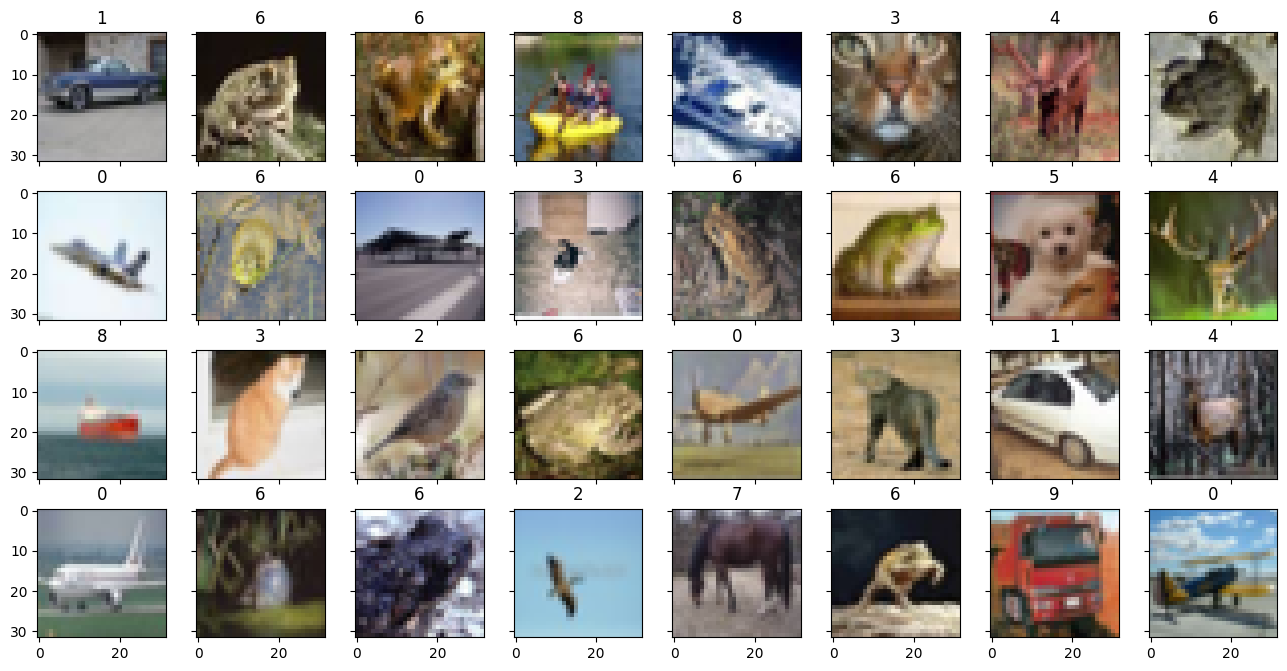

In [5]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

## Data Generator with Patch Augmentation

In [6]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [7]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
valgen = createAugment(x_val, x_val)
testgen = createAugment(x_test, x_test, shuffle=False)

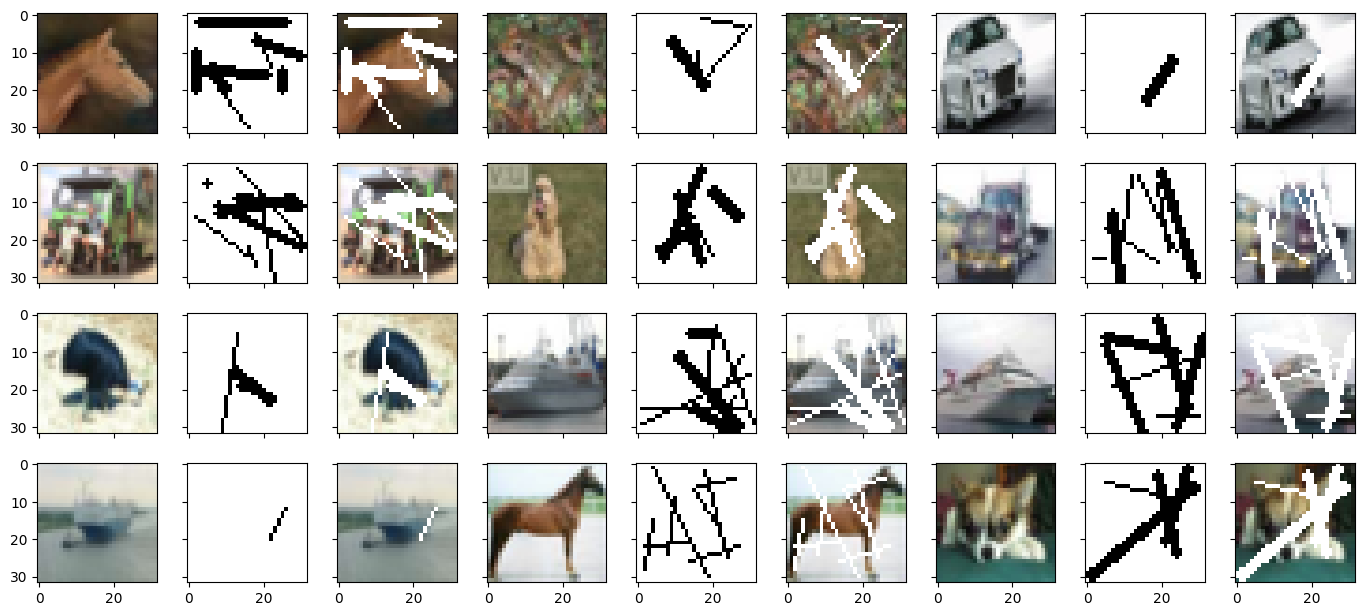

In [8]:
## Examples
sample_idx = 90 ## Change this to see different batches

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

# Define Model (Partial Convolution Based Autoencoder-Decoder Model)

In [9]:
## Metric
## Dice similarity coefficient (DSC) 
'''The Dice coefficient (Dice similarity coefficient or DSC) is a measure of overlap between two sets. It ranges from 0 to 1, where:
    - A Dice coefficient of 1 indicates perfect overlap between the two sets (i.e., the sets are identical).
    - A Dice coefficient of 0 indicates no overlap at all.'''
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def mse(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    return keras.backend.mean(keras.backend.square(y_true_f - y_pred_f))

In [10]:
class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [11]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

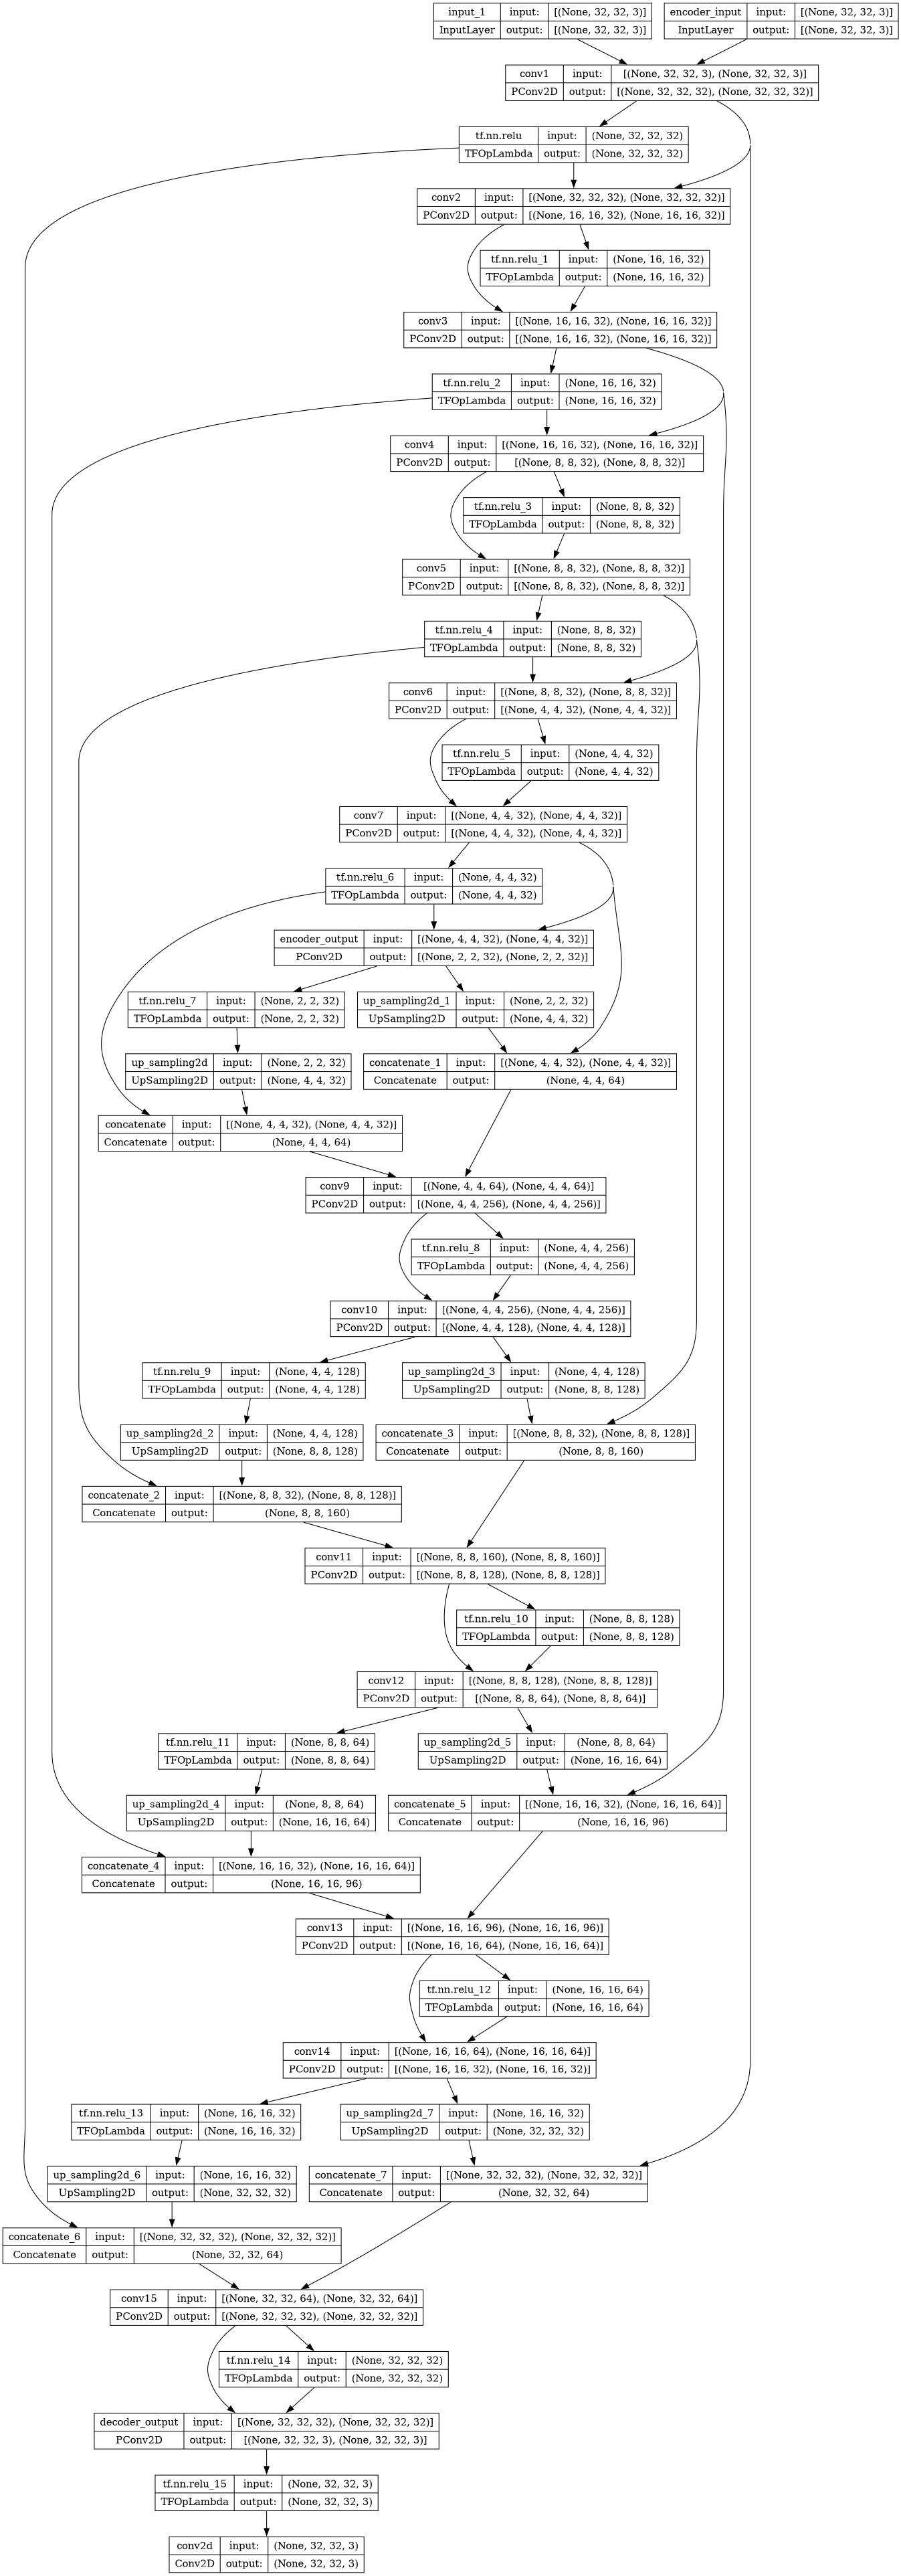

In [12]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef, mse])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

# Train Model

In [13]:
csv_logger = CSVLogger('log_training.csv', append=True, separator=';')

In [14]:
# Record the start time
start_time = time.time()

history = model.fit(traingen,
              validation_data=valgen,
              epochs=30,
              steps_per_epoch=len(traingen),
              validation_steps=len(valgen),
              callbacks=csv_logger,
              use_multiprocessing=True,)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/30


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
I0000 00:00:1717827029.487334      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1249/1250 [============================>.] - ETA: 0s - loss: 0.1196 - dice_coef: 0.5234 - mse: 0.0264

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1250/1250 [==============================] - 74s 45ms/step - loss: 0.1195 - dice_coef: 0.5234 - mse: 0.0263 - val_loss: 0.0831 - val_dice_coef: 0.5598 - val_mse: 0.0129
Epoch 2/30
1250/1250 [==============================] - 58s 46ms/step - loss: 0.0558 - dice_coef: 0.5819 - mse: 0.0064 - val_loss: 0.0455 - val_dice_coef: 0.5957 - val_mse: 0.0042
Epoch 3/30
1250/1250 [==============================] - 58s 46ms/step - loss: 0.0438 - dice_coef: 0.5939 - mse: 0.0040 - val_loss: 0.0416 - val_dice_coef: 0.5969 - val_mse: 0.0037
Epoch 4/30
1250/1250 [==============================] - 58s 46ms/step - loss: 0.0397 - dice_coef: 0.5966 - mse: 0.0035 - val_loss: 0.0381 - val_dice_coef: 0.5990 - val_mse: 0.0034
Epoch 5/30
1250/1250 [==============================] - 57s 45ms/step - loss: 0.0373 - dice_coef: 0.5976 - mse: 0.0033 - val_loss: 0.0363 - val_dice_coef: 0.6013 - val_mse: 0.0032
Epoch 6/30
1250/1250 [==============================] - 57s 46ms/step - loss: 0.0357 - dice_coef: 0.5979 - mse:

## Visualize Progress

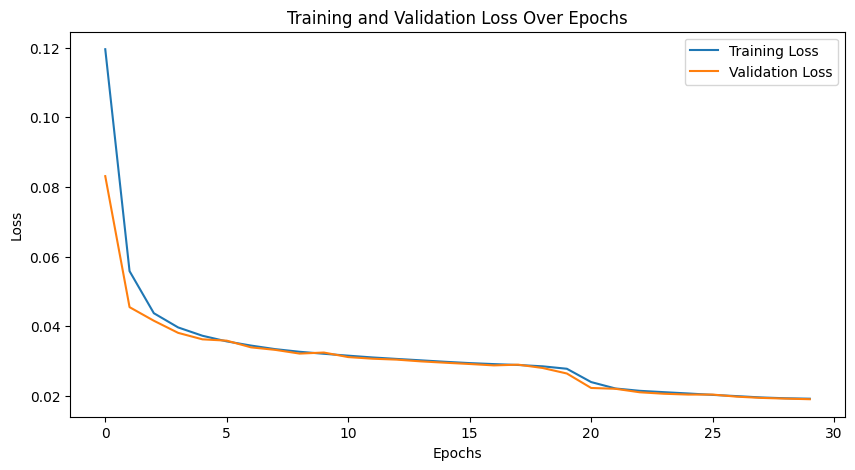

In [15]:
# Extract loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


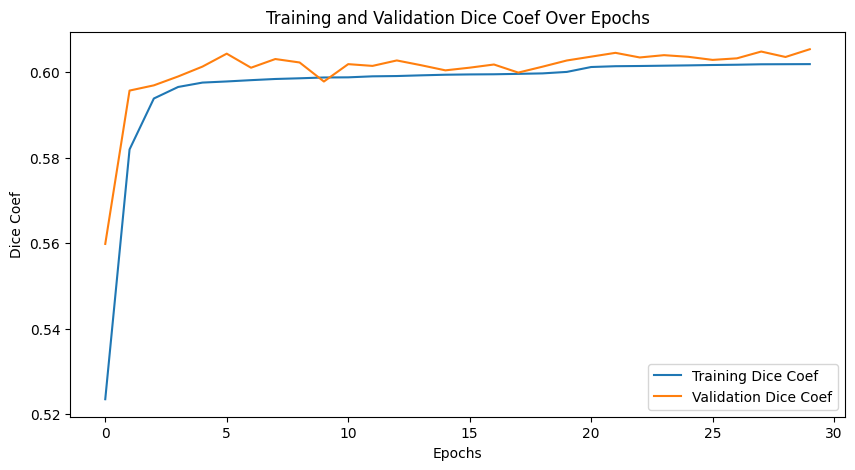

In [16]:
# Extract dice coef values from the history
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Plot the training and validation dice coef
plt.figure(figsize=(10, 5))
plt.plot(train_dice_coef, label='Training Dice Coef')
plt.plot(val_dice_coef, label='Validation Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.title('Training and Validation Dice Coef Over Epochs')
plt.legend()
plt.show()

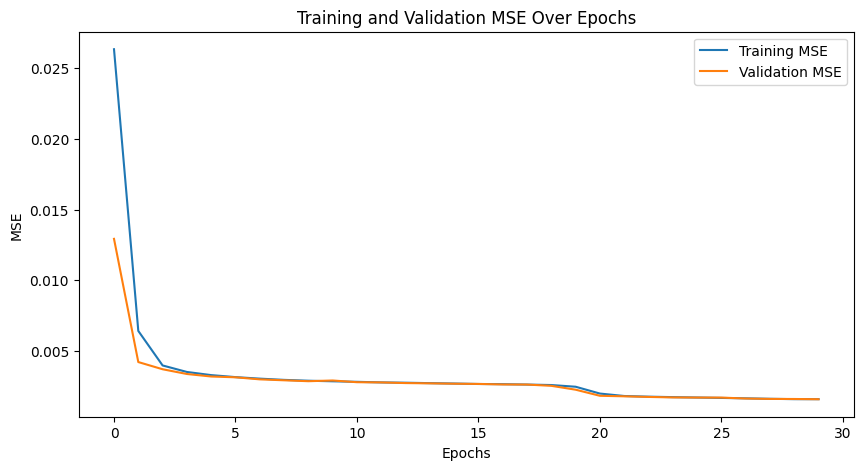

In [17]:
# Extract mse values from the history
train_mse = history.history['mse']
val_mse = history.history['val_mse']

# Plot the training and validation mse
plt.figure(figsize=(10, 5))
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE Over Epochs')
plt.legend()
plt.show()

## Save Model

In [18]:
model.save('model_inpainting.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

In [19]:
# Evaluate the model on the test data
test_loss, test_dice_coef, test_mse = model.evaluate(testgen, steps=len(testgen))
print(f'Test loss (MAE): {test_loss}')
print(f'Test dice coef: {test_dice_coef}')
print(f'Test MSE: {test_mse}')

312/312 [==============================] - 4s 12ms/step - loss: 0.0191 - dice_coef: 0.6053 - mse: 0.0016
Test loss (MAE): 0.019119178876280785
Test dice coef: 0.6052913665771484
Test MSE: 0.0015762039693072438


1/1 [==============================] - 0s 23ms/step


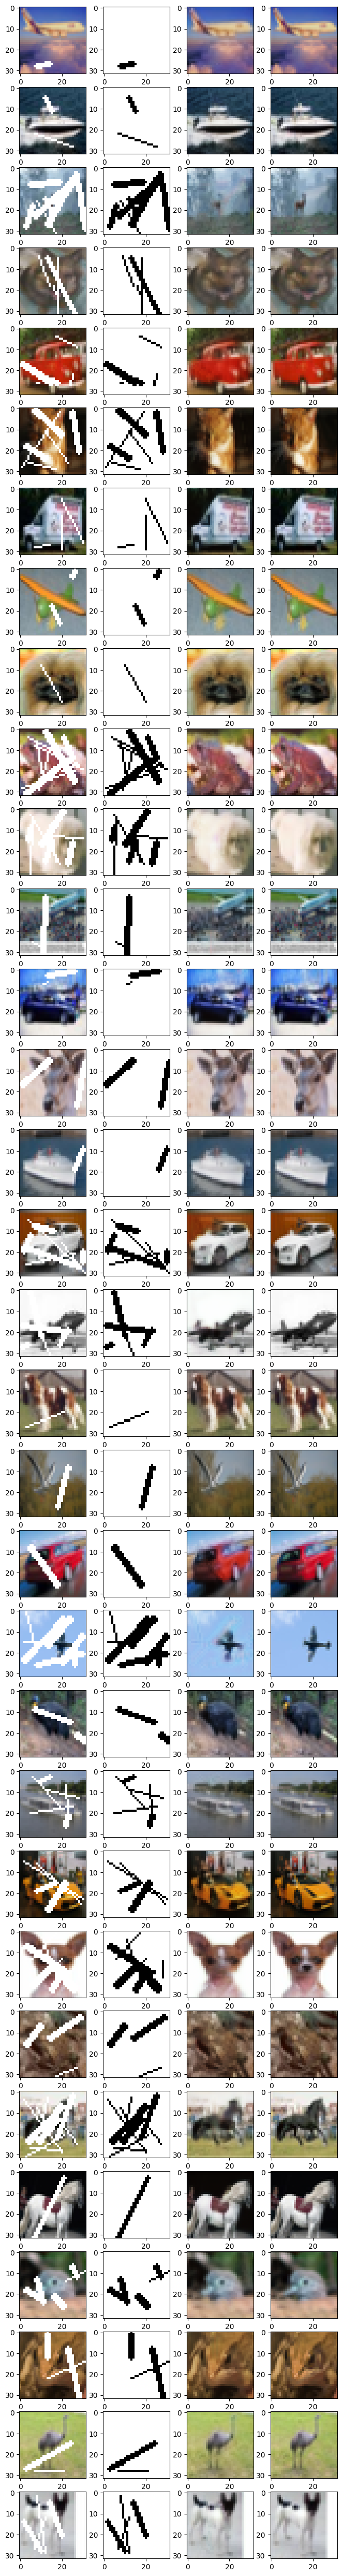

In [20]:
## Examples
rows = 32
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])
  
plt.show()